# Daymet Historical Baseline Exploratory Data Analysis

The purpose of this notebook is to perform exploratory data analysis (EDA) for the NCAR Daymet historical baseline data that was used to statistically downscale (BCSD) the Alaska Near Surface Meteorology Daily Averages dataset. The data are 12 km resolution for the period 1980–2017, and were aggregated from the 1 km resolution Daymet dataset version 3 (Thornton et al. 2016). Per the article that describes this dataset:

The length of observed data...(37 years)...is shorter than the 50-year record used for CONUS hydroclimate projection work. With a shorter length observational dataset, the uncertainty in extreme events in the downscaled product may become greater because the short observation record length increases the uncertainty in the tails (extreme events) of the observed cumulative distribution used for quantile mapping based bias correction (Wood et al., 2004).

The goal of this EDA notebook is to execute some of the normal tasks (what is here? what is missing? etc.) and understand the structures and value ranges within the data.


In [1]:
import os
import time
from pathlib import Path

import xarray as xr
from tqdm import tqdm
import numpy as np
import dask
import dask.array as da
from dask.distributed import Client
from dask import delayed
import pandas as pd
import matplotlib.pyplot as plt

from config import daymet_dir

In [2]:
# make sure all the files are in place
daymet_files = list(daymet_dir.glob("*.nc"))
# Daymet baseline runes 1980 through 2017 so there should be 38 files
assert len(daymet_files) == 38

In [3]:
# the Daymet data should be homogenous in structure, let's check
# first we'll check one file and use it as a reference
with xr.open_dataset(daymet_dir / "daymet_met_1988.nc") as ds:
    ref_coords = ds.coords
    ref_dims = ds.dims
    ref_indices = ds.indexes

In [4]:
ref_coords["time"].shape[0]

366

In [5]:
ref_indices

Indexes:
    time     DatetimeIndex(['1988-01-01 12:00:00', '1988-01-02 12:00:00',
               '1988-01-03 12:00:00', '1988-01-04 12:00:00',
               '1988-01-05 12:00:00', '1988-01-06 12:00:00',
               '1988-01-07 12:00:00', '1988-01-08 12:00:00',
               '1988-01-09 12:00:00', '1988-01-10 12:00:00',
               ...
               '1988-12-22 12:00:00', '1988-12-23 12:00:00',
               '1988-12-24 12:00:00', '1988-12-25 12:00:00',
               '1988-12-26 12:00:00', '1988-12-27 12:00:00',
               '1988-12-28 12:00:00', '1988-12-29 12:00:00',
               '1988-12-30 12:00:00', '1988-12-31 12:00:00'],
              dtype='datetime64[ns]', name='time', length=366, freq=None)

In [6]:
ref_dims

Frozen({'y': 209, 'x': 299, 'time': 366})

In [7]:
ref_coords

Coordinates:
  * time     (time) datetime64[ns] 1988-01-01T12:00:00 ... 1988-12-31T12:00:00

In [8]:
misfit_files = []

for nc_file in tqdm(daymet_files):
    with xr.open_dataset(nc_file) as ds:

        # check data is three dimensional (time) and dim lengths match reference
        dims = list(ds.dims.values())
        if sorted(dims) != sorted(list(ds.dims.values())):
            print(f"{nc_file.name} has unusual dimensions of {dims}")
            misfit_files.append(nc_file)

        # check expected variables exist in each file as a DataArray
        data_vars = set(list(ds.data_vars.keys()))
        if "tmin" in data_vars and "tmax" in data_vars:
            pass
        else:
            print(f"{nc_file.name} only has the following data variables: {data_vars}")
            misfit_files.append(nc_file)

        
time.sleep(0.5) # just deconflicts output from the tqdm bar sometiems they get all garbled
if len(misfit_files) == 0:
    print("Source data are homogeneous.")
else:
    print("These files deviate from the reference:")
    print(np.unique(misfit_files))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 57.17it/s]


Source data are homogeneous.


Next we will check the value ranges for `tmin` and `tmax`. These data are in C (will be converted to F later). Here are some historical, actual record temperature bounds from Wikipedia:
 - highest is 100 °F (38 °C) in Fort Yukon
 - lowest is −80 °F (−62 °C) in Prospect Creek

In [9]:
# define a delayed function to compute stats for all variables for a single file
@delayed
def compute_stats_for_file(file):
    with xr.open_dataset(file) as ds:
        file_stats = {}
        for variable in ["tmin", "tmax"]:
            da = ds[variable].chunk()  # chunk the data for parallel processing
            file_stats[variable] = {"filename": file.name,
                                    "min_vals": float(da.min()),
                                    "max_vals": float(da.max()),
                                    "nan_count": float(da.isnull().sum()), # also checking for a constant count of no data cells while we are "in here"
                                   }
        return file_stats

In [10]:
client = Client()

summary_stat_di = {}
all_file_stats = []

for nc_file in tqdm(daymet_files):
    all_file_stats.append(compute_stats_for_file(nc_file))
stat_result = dask.compute(*all_file_stats)
init_df = pd.DataFrame.from_dict(stat_result).T
        
client.close()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 7316.88it/s]


In [11]:
# each column of the df contains a dict of summary statistics from one file
# each row of the df corresponds to a variable
# transform this such that each dict key is a column, and each row is a file

output_dfs = []

for idx in init_df.index:
    row_dict = init_df.loc[idx].to_dict()
    df = pd.DataFrame(row_dict).T
    df["variable"] = idx
    output_dfs.append(df)
summary_stat_di = pd.concat(output_dfs)

In [12]:
# so we reported on the min and max value found in each file
# here are the minimums from all files
# looks good, nothing is lower than the historic low of -62 C
summary_stat_di.drop(["filename"], axis=1).groupby("variable").min().round(1)

,min_vals,max_vals,nan_count
variable,,,
tmax,-50.0,28.9,17607965.0
tmin,-51.0,14.5,17607965.0


In [13]:
# here are the maximums from all files
# we do exceed that 38 C historical record, but it is by a reasonable amount IMO 
summary_stat_di.drop(["filename"], axis=1).groupby("variable").max().round(1)

,min_vals,max_vals,nan_count
variable,,,
tmax,-50.0,40.6,17656206.0
tmin,-51.0,23.0,17656206.0


In [14]:
# at first it seems like something is wrong
np.unique(summary_stat_di["nan_count"], return_counts=True)

(array([17607965.0, 17656206.0], dtype=object), array([56, 20]))

In [15]:
summary_stat_di[summary_stat_di["nan_count"] == 17656206]

,filename,min_vals,max_vals,nan_count,variable
0,daymet_met_1980.nc,-51.0,16.0,17656206.0,tmin
4,daymet_met_1984.nc,-51.0,15.5,17656206.0,tmin
8,daymet_met_1988.nc,-51.0,18.622574,17656206.0,tmin
12,daymet_met_1992.nc,-51.0,18.5,17656206.0,tmin
16,daymet_met_1996.nc,-51.0,15.261895,17656206.0,tmin
20,daymet_met_2000.nc,-51.0,20.5,17656206.0,tmin
24,daymet_met_2004.nc,-51.0,22.959425,17656206.0,tmin
28,daymet_met_2008.nc,-51.0,18.0,17656206.0,tmin
32,daymet_met_2012.nc,-51.0,17.851229,17656206.0,tmin
36,daymet_met_2016.nc,-51.0,19.0,17656206.0,tmin


But these are just leap years where the no data count is more than non-leap years because they have an extra day.

In [16]:
# Next we will plot some of the extreme value time slices for each variable.
met_tmin_df = summary_stat_di.set_index("filename").query("variable == 'tmin'")
met_tmax_df = summary_stat_di.set_index("filename").query("variable == 'tmax'")
min_tmin = met_tmin_df.sort_values("max_vals").index[0]
max_tmax = met_tmax_df.sort_values("max_vals").index[-1]

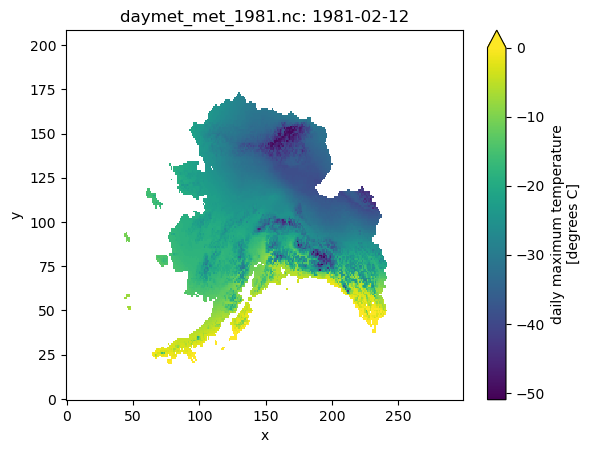

In [17]:
with xr.open_dataset(daymet_dir / min_tmin) as ds:
    
    da = ds.tmin
    min_val = da.min()
    min_loc = da.argmin()

    min_loc_tuple = np.unravel_index(min_loc, da.shape)

    # Extract the time coordinate of the min value
    time_slice = da.time[min_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]

    da.sel(time=time_slice).plot(vmax=0)
    plt.title(f"{min_tmin}: {tstr}")

So we can see that Feb 12 1981 was the day with coldest value in our time series.
Also, notice that the source data have the incorrect description written in the attributes for the data variable.
This is tmin, but the y-axis is auto plotting the label of "daily max temperature".

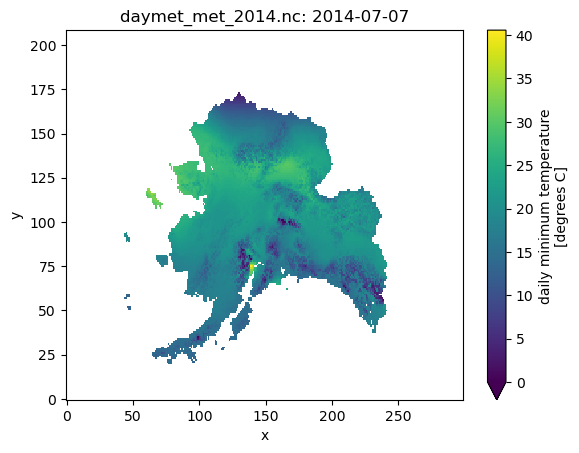

In [18]:
# and now the maximum
with xr.open_dataset(daymet_dir / max_tmax) as ds:
    
    da = ds.tmax
    max_val = da.max()
    max_loc = da.argmax()

    max_loc_tuple = np.unravel_index(max_loc, da.shape)

    time_slice = da.time[max_loc_tuple[0]]
    tstr = time_slice.values.astype(str).split("T")[0]
    da.sel(time=time_slice).plot(vmin=0)
    plt.title(f"{max_tmax}: {tstr}")

July 7, 2014 had the hottest value. Same deal on the swapped "minimum" vs. "maximum" temperature labels.

## EDA Takeaways
* data are generally homogenous
* the data variables `tmin` and `tmax` have reasonable extreme values
* these data contain leap years
* if you are plotting slices of the source data, beware that the auto-labeling will be incorrect for tmin/tmax